### 80

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [184]:
newsdf=pd.read_csv("src/newcorpora/newsCorpora.csv",header=None,sep="\t", names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'],quoting=3)
newsdf=newsdf[newsdf.PUBLISHER.isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"])][["CATEGORY","TITLE"]]
train,test=train_test_split(newsdf,test_size=0.2,stratify=newsdf.CATEGORY)
valid,test=train_test_split(test,test_size=0.5,stratify=test.CATEGORY)
train.to_csv('src/newcorpora/train.txt', index=False, sep="\t",header=None)
valid.to_csv('src/newcorpora/valid.txt', index=False, sep="\t",header=None)
test.to_csv('src/newcorpora/test.txt', index=False, sep="\t",header=None)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import string
import re
import numpy as np

In [2]:
def normalizeText(text):
    text = text.lower()  # 小文字化
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
#     text = re.sub('[0-9|,|.]+', '0', text)
    text = text.translate(table)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"^ | $", "", text)
    return text

In [3]:
train=pd.read_csv('src/newcorpora/train.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
valid=pd.read_csv('src/newcorpora/valid.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
test=pd.read_csv('src/newcorpora/test.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])

In [4]:
Cntvec = CountVectorizer(min_df=2)

train_vec=Cntvec.fit_transform(train.TITLE.map(lambda x: normalizeText(x))).toarray()
valid_vec=Cntvec.transform(valid.TITLE.map(lambda x: normalizeText(x))).toarray()
test_vec=Cntvec.transform(test.TITLE.map(lambda x: normalizeText(x))).toarray()

In [5]:
word_sum=train_vec.sum(axis=0)
idx=word_sum.argsort()[::-1]
word_list=np.array(Cntvec.get_feature_names())[idx]
word_id_dict=dict(zip(word_list,range(1,len(word_list)+1)))
# word_cnt_dict=dict(zip(word_list, word_sum))

In [6]:
def gen_ID_List(sentence):
    l=[]
    for word in sentence.split():
        wdID=word_id_dict.get(word,0)
        l.append(wdID)
    return l

### 81

## モデル作成

rnn の活性化はデフォルトでtanh  
中間層は大きめに設定して正則化をするのが良いらしい？(普通のNN)

In [2]:
import torch
import torch.nn  as nn

In [226]:
INPUT_SIZE=300 # d_w
HIDDEN_SIZE=50 # d_h
PADDING_IDX = len(word_list)
VOCAB_SIZE=len(word_list)+1
L=4
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb=nn.Embedding(VOCAB_SIZE, INPUT_SIZE) # onehotに変換して単語ベクトルに変換する関数
        
        self.hidden_size = HIDDEN_SIZE
        #input tensor :(batch, seq_len, input_size)
        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE,batch_first=True)
        
        self.fc = nn.Linear(HIDDEN_SIZE,L)
    def forward(self,x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()
        
        x=self.emb(x)
        y, hidden = self.rnn(x,hidden)
        y = self.fc(y[:,-1,:]) # 出力の最後だけを結果として渡す
        return y
    #RNNのデフォルトの層は1
    def init_hidden(self):
        hidden = torch.zeros(1,self.batch_size, self.hidden_size)
        return hidden

In [9]:
emb=nn.Embedding(VOCAB_SIZE, INPUT_SIZE)

In [10]:
text=normalizeText(valid.TITLE[10])
x=torch.tensor(gen_ID_List(text))

In [11]:
emb(x)

tensor([[-0.1102,  0.7828, -0.3399,  ...,  1.6307, -0.2476,  1.5979],
        [ 0.2167, -0.5309,  0.1570,  ..., -0.4870, -0.0092,  0.1849],
        [-0.1388, -0.8580, -0.9727,  ..., -0.3298, -1.1719, -0.4177],
        ...,
        [ 0.0703, -1.5975, -0.2642,  ..., -0.5586,  0.1703,  1.2075],
        [-0.9074, -0.6535,  1.3424,  ..., -0.8454, -1.0196,  0.1668],
        [ 1.9585, -0.8960, -0.3635,  ..., -0.0266, -0.7370,  0.9205]],
       grad_fn=<EmbeddingBackward>)

## データセット作成

In [3]:
from torch.utils.data import Dataset

# https://qiita.com/yamaru/items/c5f87d55d00066f8ad7cより

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
          'inputs': torch.tensor(inputs, dtype=torch.int64),
          'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [13]:
X_train=np.array(list(map(gen_ID_List, train.TITLE.map(lambda x: normalizeText(x)))))
X_valid=np.array(list(map(gen_ID_List, valid.TITLE.map(lambda x: normalizeText(x)))))
X_test=np.array(list(map(gen_ID_List, test.TITLE.map(lambda x: normalizeText(x)))))

y_train=train["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_valid=valid["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_test=test["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})

In [14]:
def tokenizer(text, word_id_dict=word_id_dict):
    text = normalizeText(text)
    return [word_id_dict.get(word, 0) for word in text.split()]

In [15]:
y_train=train["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3}).values
y_valid=valid["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3}).values
y_test=test["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3}).values

In [16]:
dataset_train=CreateDataset(train.TITLE, y_train, tokenizer)
dataset_valid=CreateDataset(valid.TITLE, y_valid, tokenizer)
dataset_test=CreateDataset(test.TITLE, y_test, tokenizer)

## 動かす

In [17]:
Softmax = nn.Softmax(dim=-1)

In [18]:
rnnModel=RNN()

In [19]:
X = dataset_train[0]['inputs']

In [20]:
Softmax(rnnModel(X.unsqueeze(0))) # unsqueeze:次元増やしておく

tensor([[0.2616, 0.1651, 0.3549, 0.2185]], grad_fn=<SoftmaxBackward>)

In [21]:
for i in range(10):
    X = dataset_train[i]['inputs']
    print(Softmax(rnnModel(X.unsqueeze(0))))

tensor([[0.2616, 0.1651, 0.3549, 0.2185]], grad_fn=<SoftmaxBackward>)
tensor([[0.1228, 0.2992, 0.2415, 0.3365]], grad_fn=<SoftmaxBackward>)
tensor([[0.1253, 0.2896, 0.2519, 0.3332]], grad_fn=<SoftmaxBackward>)
tensor([[0.3708, 0.1570, 0.2776, 0.1946]], grad_fn=<SoftmaxBackward>)
tensor([[0.1139, 0.2865, 0.2337, 0.3660]], grad_fn=<SoftmaxBackward>)
tensor([[0.1150, 0.5302, 0.1641, 0.1907]], grad_fn=<SoftmaxBackward>)
tensor([[0.3503, 0.2588, 0.1834, 0.2075]], grad_fn=<SoftmaxBackward>)
tensor([[0.2573, 0.2992, 0.2568, 0.1867]], grad_fn=<SoftmaxBackward>)
tensor([[0.2176, 0.2752, 0.1635, 0.3437]], grad_fn=<SoftmaxBackward>)
tensor([[0.1213, 0.1933, 0.3956, 0.2898]], grad_fn=<SoftmaxBackward>)


### 82

In [22]:
from tqdm import tqdm

In [21]:
from torch.utils.tensorboard import SummaryWriter

In [24]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [25]:
device = torch.device('cpu')

In [25]:
def is_equal_pred(pred_y,true_y):
    return Softmax(pred_y).argmax(axis=1) == true_y

def train_step(train_X, train_y):
    rnnModel.train()
    pred_y = rnnModel(train_X)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        n=len(train_y)
        acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step(valid_X, valid_y):
    rnnModel.eval()
    pred_y = rnnModel(valid_X)
    
    loss = criterion(pred_y, valid_y)
    
    with torch.no_grad():
        n=len(valid_y)
        acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

In [49]:
!rm -rf ./logs

rnnModel=RNN()

rnnModel = rnnModel.to(device)

Softmax = nn.Softmax(dim=1)

optimizer = optim.SGD(
    rnnModel.parameters(),
    lr=0.001)

criterion = nn.CrossEntropyLoss()

BATCHSIZE=1 # 固定長じゃないとBATCHは動かない

ds_train = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True)
ds_valid = DataLoader(dataset_valid, batch_size=BATCHSIZE, shuffle=True)

In [19]:
%load_ext tensorboard

In [437]:
%tensorboard --logdir ./logs

EPOCHS = 10

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for data in ds_train:
        train_loss, train_acc = train_step(data["inputs"].to(device),data["labels"].to(device))
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for data in ds_valid:
        valid_loss, valid_acc=valid_step(data["inputs"].to(device),data["labels"].to(device))
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

100%|██████████| 10/10 [11:16<00:00, 67.62s/it]


### 83

## ボツ案：collate_fnで最大系列長に合わせてパディングする

In [51]:
### https://qiita.com/yamaru/items/c5f87d55d00066f8ad7c
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [61]:
!rm -rf ./logs

rnnModel=RNN()

rnnModel = rnnModel.to(device)

Softmax = nn.Softmax(dim=1)

optimizer = optim.SGD(
    rnnModel.parameters(),
    lr=0.001)

criterion = nn.CrossEntropyLoss()

BATCHSIZE=1

ds_train = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True, collate_fn=Padsequence(PADDING_IDX))
ds_valid = DataLoader(dataset_valid, batch_size=BATCHSIZE, shuffle=True, collate_fn=Padsequence(PADDING_IDX))

In [537]:
%tensorboard --logdir ./logs

EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for data in ds_train:
        train_loss, train_acc = train_step(data["inputs"].to(device),data["labels"].to(device))
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for data in ds_valid:
        valid_loss, valid_acc=valid_step(data["inputs"].to(device),data["labels"].to(device))
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

Reusing TensorBoard on port 6006 (pid 28836), started 0:03:07 ago. (Use '!kill 28836' to kill it.)

 86%|████████▌ | 86/100 [06:22<01:02,  4.45s/it]


KeyboardInterrupt: 

## torchtext

In [4]:
import spacy
spacy_en = spacy.load('en')
def tokenizer(text):
    text = re.sub(r" +", r" ", text).strip()
#     return [tok.text for tok in spacy_en.tokenizer(text) if tok.text not in string.punctuation]
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text not in string.punctuation]

In [5]:
from torchtext import data
from torchtext import datasets

In [7]:
device=torch.device("cpu")

In [8]:
batch_size=32

LABEL = data.Field(sequential=False, batch_first=True, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first=True)
#sequential: 可変長か
# futurewaningとかいっぱい出るけど無視
train, val, test = data.TabularDataset.splits(
        path='src/newcorpora/', train='train2.txt',
        validation='valid2.txt', test='test2.txt', format='tsv',
        fields=[('Label', LABEL),('Text', TEXT)])

TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = data.Iterator.splits(
    (train, val, test), batch_sizes=(batch_size, batch_size, batch_size), device=device, repeat=False, sort=False,shuffle=True)

/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtex

In [10]:
!rm -rf ./logs

device=torch.device('cpu')

rnnModel=RNN()

rnnModel = rnnModel.to(device)

Softmax = nn.Softmax(dim=-1)

optimizer = optim.SGD(
    rnnModel.parameters(),
    lr=0.01)

criterion = nn.CrossEntropyLoss()

In [257]:
%tensorboard --logdir ./logs

EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in train_iter:
        train_loss, train_acc = train_step(d.Text, d.Label)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in train_iter:
        valid_loss, valid_acc=valid_step(d.Text, d.Label)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

Reusing TensorBoard on port 6006 (pid 49172), started 0:03:45 ago. (Use '!kill 49172' to kill it.)

100%|██████████| 100/100 [06:58<00:00,  4.18s/it]


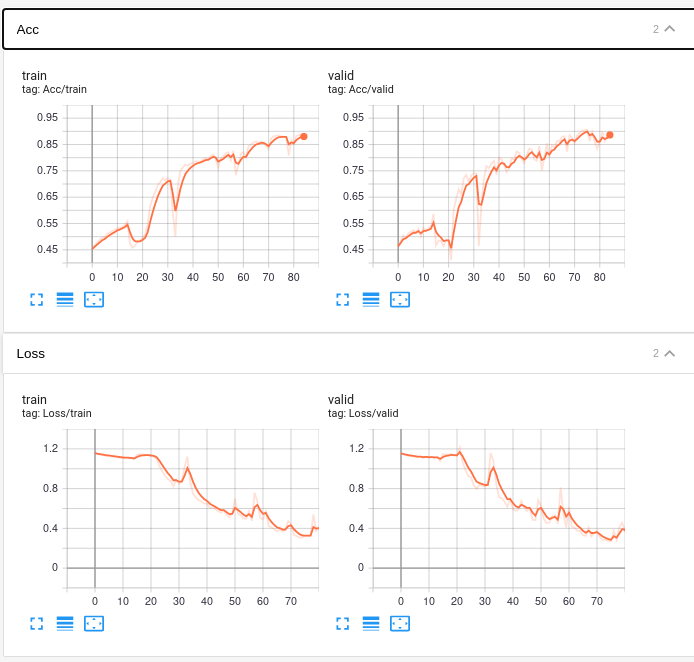

### 84

In [7]:
import torch
import torch.nn as nn

In [6]:
from gensim.models import KeyedVectors
w2vModel = KeyedVectors.load_word2vec_format('src/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [8]:
VOCAB_SIZE=len(TEXT.vocab.itos)
EMB_SIZE=300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
for word in TEXT.vocab.itos:
    idx = TEXT.vocab.stoi[word]
    if word in w2vModel.vocab:
        weights[idx] = w2vModel[word]
weights=torch.FloatTensor(weights)

In [11]:
def is_equal_pred(pred_y,true_y):
    return Softmax(pred_y).argmax(axis=1) == true_y

def train_step(train_X, train_y,model):
    model.train()
    pred_y = model(train_X)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        n=len(train_y)
        acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step(valid_X, valid_y,model):
    model.eval()
    pred_y = model(valid_X)
    
    loss = criterion(pred_y, valid_y)
    
    with torch.no_grad():
        n=len(valid_y)
        acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

In [42]:
INPUT_SIZE=300 # d_w
HIDDEN_SIZE=50 # d_h
L=4
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding.from_pretrained(weights,padding_idx=1)
#         self.emb=nn.Embedding(VOCAB_SIZE, INPUT_SIZE,padding_idx=1) 
        self.hidden_size = HIDDEN_SIZE
        #input tensor :(batch, seq_len, input_size)
        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE,batch_first=True)
        
        self.fc = nn.Linear(HIDDEN_SIZE,L)
    def forward(self,x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()
        
        x=self.emb(x)
        y, hidden = self.rnn(x,hidden)
        y = self.fc(y[:,-1,:]) # 出力の最後だけを結果として渡す
        return y
    #RNNのデフォルトの層は1
    def init_hidden(self):
        hidden = torch.zeros(1,self.batch_size, self.hidden_size)
        return hidden

In [13]:
import torch.optim as optim

In [44]:
batch_size=32

LABEL = data.Field(sequential=False, batch_first=True, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first=True)
#sequential: 可変長か
# futurewaningとかいっぱい出るけど無視
train, val, test = data.TabularDataset.splits(
        path='src/newcorpora/', train='train2.txt',
        validation='valid2.txt', test='test2.txt', format='tsv',
        fields=[('Label', LABEL),('Text', TEXT)])

TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = data.Iterator.splits(
    (train, val, test), batch_sizes=(batch_size, batch_size, batch_size), device=device, repeat=False, sort=False,shuffle=True)

/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtex

In [53]:
!rm -rf ./logs

device=torch.device('cpu')

rnnModel=RNN()

rnnModel = rnnModel.to(device)

Softmax = nn.Softmax(dim=1)

optimizer = optim.SGD(
    rnnModel.parameters(),
    lr=0.001)

criterion = nn.CrossEntropyLoss()

In [22]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [17]:
%load_ext tensorboard

In [38]:
writer.close()

In [54]:
%tensorboard --logdir ./logs

EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in train_iter:
        train_loss, train_acc = train_step(d.Text, d.Label)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in train_iter:
        valid_loss, valid_acc=valid_step(d.Text, d.Label)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


### 85

In [77]:
INPUT_SIZE=300 # d_w
HIDDEN_SIZE=50 # d_h
L=4
class RNN(nn.Module):
    def __init__(self, num_layers=1, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        self.emb = nn.Embedding.from_pretrained(weights,padding_idx=1)
#         self.emb=nn.Embedding(VOCAB_SIZE, INPUT_SIZE,padding_idx=1) 
        self.hidden_size = HIDDEN_SIZE
        #input tensor :(batch, seq_len, input_size)
        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE,num_layers,batch_first=True, bidirectional=bidirectional)
        
        self.fc = nn.Linear(HIDDEN_SIZE*self.num_directions,L)
    def forward(self,x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()
        
        x=self.emb(x)
        y, hidden = self.rnn(x,hidden)
        y = self.fc(y[:,-1,:]) # 出力の最後だけを結果として渡す
        return y
    #RNNのデフォルトの層は1
    def init_hidden(self):
        hidden = torch.zeros(self.num_layers*self.num_directions,self.batch_size, self.hidden_size)
        return hidden
    
    
# self.rnn1 = torch.nn.RNN(INPUT_SIZE,HIDDEN_SIZE,bidirectional=True,batch_first=True)
# self.rnn2 = torch.nn.RNN(2*HIDDEN_SIZE,HIDDEN_SIZE,bidirectional=True,batch_first=True)
# self.rnn3 = torch.nn.RNN(2*HIDDEN_SIZE,HIDDEN_SIZE,bidirectional=True,batch_first=True)
# self.linear = torch.nn.Linear(2*HIDDEN_SIZE,4)

# x = self.emb(x)
# y, h = self.rnn1(x, h)
# y, h = self.rnn2(y, h)
# y, h = self.rnn3(y, h)
# y = y[:,-1,:] # 最後のステップ
# y = self.linear(y)

In [73]:
rnnModel.init_hidden().shape

torch.Size([2, 32, 50])

In [80]:
%tensorboard --logdir ./logs

rnnModel=RNN(num_layers=1, bidirectional=True)

rnnModel = rnnModel.to(device)

optimizer = optim.SGD(
    rnnModel.parameters(),
    lr=0.001)
EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in train_iter:
        train_loss, train_acc = train_step(d.Text, d.Label)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in train_iter:
        valid_loss, valid_acc=valid_step(d.Text, d.Label)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

Reusing TensorBoard on port 6006 (pid 59697), started 1:37:26 ago. (Use '!kill 59697' to kill it.)

100%|██████████| 100/100 [04:52<00:00,  2.92s/it]


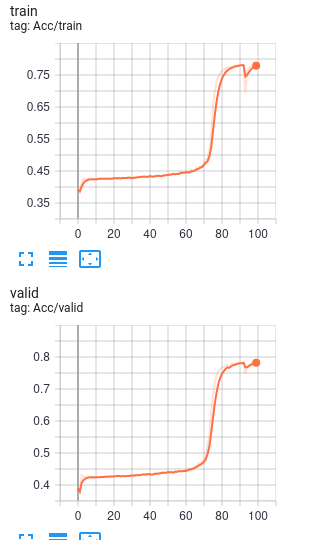

### 86

In [ ]:
import torch.nn.functional as F

In [339]:
class CNNs(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(weights,padding_idx=1)
        self.conv = nn.Conv1d(EMB_SIZE, HIDDEN_SIZE, 3,stride=1, padding=1)
        self.linear = nn.Linear(HIDDEN_SIZE,4)
    def forward(self,x):
        h=self.emb(x)
        h=self.conv(h.transpose(1,2))
        h=F.relu(h)
        h=F.max_pool1d(h,h.size(2)).squeeze(2)
        y=self.linear(h)
        return y

In [326]:
#こういう仕組み
x=emb(j.Text)
print(x.shape)
x1=conv(x.transpose(1,2))
print(x1.shape)
x2=ReLu(x1)
print(x2.shape)
x3=F.max_pool1d(x2,x2.size(2)).squeeze(2)
print(x3.shape)
y=linear(x3)
print(y.shape)

torch.Size([32, 14, 300])
torch.Size([32, 50, 14])
torch.Size([32, 50, 14])
torch.Size([32, 50])
torch.Size([32, 4])


In [360]:
cnnModel=CNNs()
Softmax=nn.Softmax(dim=1)
y=cnnModel(x)
print(y)

tensor([[-0.0513,  0.1421,  0.1135, -0.0101],
        [-0.0744,  0.0792,  0.0934, -0.0161],
        [-0.0552,  0.1530,  0.1005, -0.0122],
        [-0.0904,  0.1469,  0.0744,  0.0059],
        [-0.0970,  0.1105,  0.0769, -0.0838],
        [-0.0424,  0.1307,  0.0540, -0.0050],
        [-0.1097,  0.1150,  0.0825,  0.0230],
        [-0.0761,  0.1382,  0.0917, -0.0198],
        [-0.0481,  0.1327,  0.0545,  0.0692],
        [-0.0675,  0.1794,  0.0592, -0.0251],
        [-0.0848,  0.1465,  0.0769,  0.0266],
        [-0.0814,  0.1826,  0.0485,  0.0318],
        [-0.0813,  0.1467,  0.0883, -0.0141],
        [-0.0414,  0.1742,  0.0750, -0.0048],
        [-0.1067,  0.1944,  0.0491, -0.0267],
        [-0.0846,  0.1205,  0.0933, -0.0312],
        [-0.1126,  0.1543,  0.0557, -0.0241],
        [-0.0691,  0.1678,  0.1018, -0.0123],
        [-0.0338,  0.1534,  0.0498, -0.0119],
        [-0.0847,  0.1083,  0.0841, -0.0353],
        [-0.0609,  0.1379,  0.0705,  0.0372],
        [-0.0600,  0.1687,  0.0469

### 87

In [97]:
def is_equal_pred(pred_y,true_y):
    return Softmax(pred_y).argmax(axis=1) == true_y

def train_step(train_X, train_y,model):
    model.train()
    pred_y = model(train_X)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        n=len(train_y)
        acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step(valid_X, valid_y,model):
    model.eval()
    pred_y = model(valid_X)
    
    loss = criterion(pred_y, valid_y)
    
    with torch.no_grad():
        n=len(valid_y)
        acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

In [376]:
!rm -rf ./logs
cnnModel=CNNs()
cnnModel=cnnModel.to(device)
optimizer = optim.SGD(
    cnnModel.parameters(),
    lr=0.01)

In [377]:
%tensorboard --logdir ./logs

EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in train_iter:
        train_loss, train_acc = train_step(d.Text, d.Label,cnnModel)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in train_iter:
        valid_loss, valid_acc=valid_step(d.Text, d.Label,cnnModel)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

Reusing TensorBoard on port 6006 (pid 72717), started 0:04:51 ago. (Use '!kill 72717' to kill it.)

  0%|          | 0/100 [00:00<?, ?it/s]/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


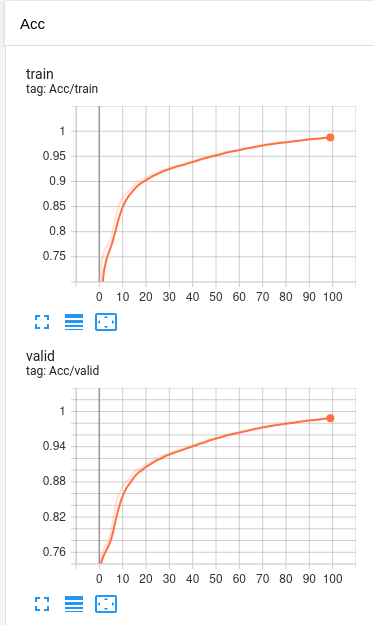

### 88

In [444]:
INPUT_SIZE=300 # d_w
HIDDEN_SIZE=50 # d_h
L=4
drop_rate = 0.3
# lstm
class LSTM(nn.Module):
    def __init__(self, num_layers=1, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        self.emb = nn.Embedding.from_pretrained(weights,padding_idx=1)
#         self.emb=nn.Embedding(VOCAB_SIZE, INPUT_SIZE,padding_idx=1) 
        self.hidden_size = HIDDEN_SIZE
        #input tensor :(batch, seq_len, input_size)
        self.lstm = nn.LSTM(EMB_SIZE, HIDDEN_SIZE,num_layers,batch_first=True, bidirectional=bidirectional, dropout=drop_rate)
        
        self.drop=nn.Dropout(drop_rate)
        
        self.fc = nn.Linear(HIDDEN_SIZE*self.num_directions,L)
    def forward(self,x,h=None):
        
        x=self.emb(x)
        y, hidden = self.lstm(x,h)
        
        y = self.fc(y[:,-1,:]) # 出力の最後だけを結果として渡す
        return y

In [446]:
!rm -rf ./logs
lstmModel=LSTM(num_layers=2,bidirectional=True)
lstmModel=lstmModel.to(device)
optimizer = optim.Adam(
    lstmModel.parameters())

In [447]:
%tensorboard --logdir ./logs
EPOCHS = 100

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in train_iter:
        train_loss, train_acc = train_step(d.Text, d.Label,lstmModel)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in val_iter:
        valid_loss, valid_acc=valid_step(d.Text, d.Label, lstmModel)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
 49%|████▉     | 49/100 [10:42<11:08, 13.11s/it]


KeyboardInterrupt: 

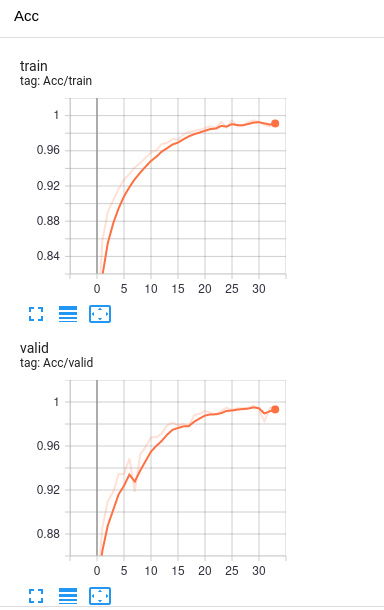

In [448]:
ans=[]
length=0
for t in test_iter:
    y=lstmModel(t.Text)
    length+=len(t.Label)
    ans.append(is_equal_pred(y,t.Label).sum())
print(np.array(ans).sum()/length)

0.9130434782608695


In [438]:
ans=[]
length=0
for t in test_iter:
    y=cnnModel(t.Text)
    length+=len(t.Label)
    ans.append(is_equal_pred(y,t.Label).sum())
print(np.array(ans).sum()/length)

0.9130434782608695


/home/yumizsui/anaconda3/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


### 89

In [12]:
from transformers import BertTokenizer, BertModel

In [466]:
from transformers import BertForSequenceClassification

In [263]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [264]:
drop_rate= 0.3
class Bert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.drop=nn.Dropout(drop_rate)
        self.linear=nn.Linear(768, 4)
    def forward(self, ids, mask):
        _, h = self.bert(ids, attention_mask=mask)
        y = self.linear(self.drop(h))
        return y

In [281]:
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len=20):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True
            
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
          'ids': torch.LongTensor(ids),
          'mask': torch.LongTensor(mask),
          'labels': self.y[index]
        }

In [185]:
train=pd.read_csv('src/newcorpora/train.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
valid=pd.read_csv('src/newcorpora/valid.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
test=pd.read_csv('src/newcorpora/test.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])

In [259]:
y_train=train["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_valid=valid["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_test=test["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})

y_train=torch.tensor(y_train)
y_valid=torch.tensor(y_valid)
y_test=torch.tensor(y_test)

In [282]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer,max_len=15)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

In [297]:
batch_size=1024
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

In [298]:
bertModel=Bert()
bertModel=bertModel.to(device)
optimizer = optim.Adam(
    bertModel.parameters(),lr=0.01)

In [266]:
def is_equal_pred(pred_y,true_y):
    return Softmax(pred_y).argmax(axis=1) == true_y

def train_step_bert(ids, mask, train_y, model):
    model.train()
    pred_y = model(ids,mask)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        n=len(train_y)
        acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step_bert(ids, mask, valid_y, model):
    model.eval()
    pred_y = model(ids,mask)
    
    loss = criterion(pred_y, valid_y)
    
    with torch.no_grad():
        n=len(valid_y)
        acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

In [ ]:
%tensorboard --logdir ./logs
EPOCHS = 30

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss_mean=[]
    train_acc_mean=[]
    for d in dataloader_train:
        
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        labels = d['labels'].to(device)
        
        train_loss, train_acc = train_step_bert(ids, mask, labels, bertModel)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
    
    valid_loss_mean=[]
    valid_acc_mean=[]
    for d in dataloader_valid:
        
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        labels = d['labels'].to(device)
        
        valid_loss, valid_acc = valid_step_bert(ids, mask, labels, bertModel)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)
    
    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

writer.close()

Reusing TensorBoard on port 6006 (pid 78408), started 1 day, 16:55:56 ago. (Use '!kill 78408' to kill it.)

  0%|          | 0/30 [00:00<?, ?it/s]